# **Documentation of community coalescence**

In [1]:
%load_ext rpy2.ipython

## **Context**

1. **Project background**：
This project is part of a big new program titled ‘A new Green Revolution: Manipulating the soil microbiome to enhance the sustainability of 21st century agriculture,’. The current focus is to optimise/engineer soil microbiomes to suppress the fungus Gaeumannomyces tritici, which causes the **take-all disease** in wheat (T. aestivum).

2. **Microbial community coalescence**：
It is the process by which two distinct microbial communities encounter one another and interact to form a new ‘daughter’ community. This assemblage may more closely resemble one ‘parent’ community than the other, and its functional profile may be totally unique. We plan to use a coalescence method to ensure resistant community is intact in order to carry out its desired function in soil.


## **Obectives**

**Can we predict winners and losers during coalescence?**

This very basic question remains relatively un-explored. However, we did have some insights on community assembly. That is, species with higher CUE value tend to survive. And there is certain connection between species richness and CUE variance.

We will use the similiar methdology as community assembly to simulate the community dynamics during coalescence, mediated by temperature. By doing that, we hope to predict the result of community coalescence through carbon usage efficiency appearance of species in different temperature. The outcome of this research will give some foundamental information for the coalescence experiments and the dealing with take-all disease project.

**Microbial Consumer Resource Model**

$$
\frac{dC_i}{dt} = \sum_{\alpha=0}^{M} C_i R_{\alpha} u_{i\alpha} (1 - \lambda_{\alpha}) - C_i m_i
$$

$$
\frac{dR_{\alpha}}{dt} = \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i=0}^{N} C_i R_{\alpha} u_{i\alpha} + \sum_{i=0}^{N} \sum_{\beta=0}^{M} C_i R_{\beta} u_{i\beta} l_{i\beta\alpha}
$$


| **Parameter** | **Description** | **Key** |
|--------------|---------------|--------|
| $C_i$ | Biomass of the $i$th consumer | - |
| $R_{\alpha}$ | Mass of the $\alpha$th resource | - |
| $N$ | Number of consumer populations | $N$ |
| $M$ | Number of resources | $M$ |
| $u_{i\alpha}$ | Uptake rate of the $\alpha$th resource by the $i$th consumer | $u$ |
| $m_i$ | Loss term for the $i$th consumer | $m$ |
| $\rho_{\alpha}$ | Inflow rate for the $\alpha$th resource | $\rho$ |
| $\omega_{\alpha}$ | Outflow term for the $j$th resource | $\omega$ |
| $l_{i\alpha\beta}$ | Proportion of uptake of the $\alpha$th resource leaked to the $\beta$th resource by $i$th consumer | $l$ |
| $\lambda_{\alpha}$ | Total proportion of the $\alpha$th resource leaked, same as $\sum_{\beta} l_{\alpha\beta}$ | $\lambda$ |


We adapt this model because it is able to capture the complex interactions of both competition for resources and the exchange of metabolic by-products.

## **Simulation:**

Import the packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import solve_ivp
import seaborn as sns
import sys
import os

In [6]:
sys.path.append(os.path.expanduser("~/Documents/MiCRM/code"))
import param

`MiCRM` is the package for simulation of Microbial Consumer Resource (MiCRM) systems. It countains some aggregated functions.

Now we  *set system size and leakage rate*

In [7]:
# Parameters
N = 20 # Number of consumers
M = 12 # Number of resources
λ = 0.3  # Total leakage rate

N is the **number of species in a community**, M is the **number of resource types**, leakage is the overall leakage rate

Next, *make uptake matrix out of dirichlet distribution*

In [8]:
# Each consumer's uptake scaling factor
λ_u = np.random.uniform(0.8, 1, N)  
σ = np.random.uniform(0.05 * λ_u, 0.2 * λ_u)
N_modules = 5  # Number of modules connecting consumers to resources
s_ratio = 4.0  # Strength of modularity

In [5]:
# Generate uptake matrix, defining consumer-resource interaction strengths
u = param_3D.modular_uptake(N, M, N_modules, s_ratio, λ_u, σ)  

The N_modules determines how many different blocks of resources will be divided into, and s_ratio determines how much will species focus on inner group resources. *More details about this function see document of functions

*Define other terms*

In [6]:
# Mortality rate for each consumer
m = np.full(N, 0.2)  
# Input rate of each resource
rho = np.full(M, 1)  
# Decay rate for each resource
omega = np.full(M, 0.01)  

m is a loss term for the the consumers. It can be simply understood as the proportion of deceased organisms.

ρ is the resource inflow amount of the system and ω is outflow rate.

Next, we *make leakage matrix out of dirichlet distribution and make it modular*

In [7]:
# Total leakage rate for each resource
lambda_alpha = np.full(M, λ)
# Generate leakage tensor representing leakage flow between consumers and resources
l = param_3D.generate_l_tensor(N, M, N_modules, s_ratio, λ)  

We make it N times to generate a unique resource leakage matrix for each consumer. Similarly to the `MiCRM.Parameters.modular_uptake`, the N_modules determines how many the different blocks of resources will be divided into, and s_ratio determines the structure of leakage.

For now, we finished the parameter part and it is time to create an **Ordinary Differential Equation Problem** object which defines the problem for the ODE solver and then solve it with the aptly solve function.
To define the ODEProblem we need to specify the initial state of the system as well as the timespan

In [8]:
# ODE system describing the dynamics of consumers (C) and resources (R)
def dCdt_Rdt(t, y):
    C = y[:N]  # Consumer populations
    R = y[N:]  # Resource concentrations
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    # Consumer growth equation
    for i in range(N):
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - lambda_alpha[alpha]) for alpha in range(M)) - C[i] * m[i]
    
    # Resource depletion and leakage equation
    for alpha in range(M):
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]  # Input and decay
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))  # Uptake by consumers
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))  # Leakage contributions
    
    return np.concatenate([dCdt, dRdt])
    
# Initial conditions: assume all consumers and resources start at concentration 1
C0 = np.full(N, 0.1)
R0 = np.full(M, 1)
Y0 = np.concatenate([C0, R0])
    
t_span = (0, 700)
t_eval = np.linspace(*t_span, 300)
sol = solve_ivp(dCdt_Rdt, t_span, Y0, t_eval=t_eval)

x0 is an initial state, a one-dimensional array (vector) of length N+M, where all elements are initialized to 1.  

The initial time is 0.0 and the final time is 700

At last, we *visualize the dynamics of system* 

## **Visualization**

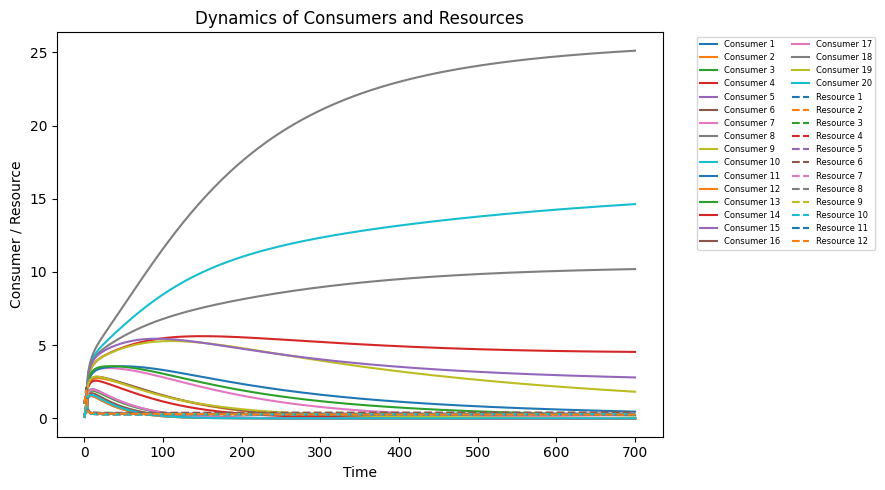

In [9]:
# Visualize system dynamics
plt.figure(figsize=(9, 5)) 

for i in range(N):
    plt.plot(sol.t, sol.y[i], label=f'Consumer {i+1}')
for alpha in range(M):
    plt.plot(sol.t, sol.y[N + alpha], label=f'Resource {alpha+1}', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Consumer / Resource')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=2, fontsize=6, columnspacing=1.5)
plt.title('Dynamics of Consumers and Resources')
plt.tight_layout()
plt.savefig("results/dynamics_of_consumers_resources.png", dpi=300, bbox_inches='tight')
plt.show()
   

Figure 1: Dynamics of consumers and resources. It displays how population of species and amount of resources change in a system

## **Calculation of carbon usage efficiency**

### **Defination**

Carbon Use Efficiency (CUE) is a key ecological functional metric that describes the proportion of assimilated carbon allocated to biomass growth compared with total carbon uptake. It is commonly used in microbial ecology and soil carbon cycling to understand how organisms utilize carbon resources.

Usually it is defined as the ratio of growth (μ) to assimilation, that is, CUE = μ/(μ + R), where R includes any Carbon losses to respiration. However, depending on the research focus, the definition of CUE may vary across different contexts.

<div style="text-align: center;">
    <img src="CUE_definition.png" width="800">
</div>


Estimates are color coded by the type of sample analyzed: soil (black), water (blue), isotopologues in soil (red), calorespirometry in soil (green) and culture-based/thermodynamics (grey). CUEP examples depict glucose (or similar) amendment. CUE carbon use efficiency, Y yield, MB microbial biomass, R respiration, BGE bacterial growth efficiency, BP bacterial production, BR bacterial respiration, MGE microbial growth efficiency, SOC soil organic carbon, CCE carbon conversion efficiency, ΔG°cat, Gibbs energy of catabolism; ΔrG°x, Gibbs energy of growth; ΔG°an, Gibbs energy of anabolism. aLinton and Stephenson (1978), bGommers et al. (1988), cBabel (2009), dTannler et al.

https://doi.org/10.1007/s10533-016-0191-y

### **Species level CUE:**


Species’ carbon use efficiency (CUE, henceforth denoted by ε) reflects the resource utilisation ability of a species. It is  usually quantified as the partitioning of harvested resources into cell growth versus carbon loss mainly through  leakage and maintenance when species grow independently and resources are abundant.

$$
\varepsilon_j = \frac{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha} \left( 1 - l_{\alpha}^{j} \right) - m_{i}(T)}
{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha}}
$$

$$
\begin{array}{|c|c|}
\hline
\textbf{Symbol} & \textbf{Meaning} \\
\hline
u_{i\alpha}(T) & \text{Uptake coefficient} \\
\hat{R}_{\alpha} & \text{Resource availability} \\
l_{\alpha}^{j} & \text{Leakage fraction} \\
m_{i}(T) & \text{Maintenance cost} \\
M & \text{Total number of resources} \\
\hline
\end{array}
$$




In [10]:
# CUE
CUE = np.zeros(N)
total_uptake = np.sum(u * R0, axis=1)  # (N × M) @ (M,) -> (N,)
net_uptake = np.sum(u * R0 *(1-lambda_alpha), axis=1)-m # Adjusted for leakage and metabolism
CUE = net_uptake/total_uptake
print(f"Carbon Use Efficiency (CUE): {CUE.tolist()}")

Carbon Use Efficiency (CUE): [0.45411571667044065, 0.4801375067633586, 0.46615346018163195, 0.49348458121957567, 0.4734143973652796, 0.48594274187504305, 0.4893401145459111, 0.49899352743686054, 0.4931774812045304, 0.4992847817711547, 0.48462072762859953, 0.45591338193139835, 0.4919523511790598, 0.4814940806999586, 0.4987491285651832, 0.4648101899168134, 0.4659753493268027, 0.4985793582306138, 0.4897864500355067, 0.4570915645241073]


### **Community level CUE:**

#### **Experimental measurement**

Some researchers use the very original defination:
$$
CUE = \frac{\text{Growth Rate}}{\text{Growth Rate} + \text{Respiration Rate}}
$$

where the amount of CO2 -C produced during the incubation period was recorded as soil respiration flux. Isotope 18O was used for the measurement of DNA change and eventually growth rate

- The increase in DNA (\(\Delta DNA\)) was calculated as:

$$
\Delta DNA = 0.33 \times \frac{\text{at\%}^{18}O_{DNA_{labeled}} - \text{at\%}^{18}O_{DNA_{natural}}}{\text{at\%}^{18}O_{water} - \text{at\%}^{18}O_{DNA_{natural}}}
$$

- **DNA increment (\(\Delta DNA\))** was converted to **microbial biomass carbon (\(\Delta MBC\))** using a linear regression model:
$$
\Delta MBC = \beta \times \Delta DNA
$$

- The final **growth rate** was calculated as:
$$
\text{Growth Rate} = \frac{\Delta MBC}{t}
$$
where \( t \) is the incubation time (24 h).

The meaning of CUE can also be defined as the fraction of consumed carbon that is converted into new microbial biomass.

Some researchers(https://journals.asm.org/doi/10.1128/aem.01851-20) quantifiedhow much carbon had been assimilated into biomass versus how much was depleted from the medium. This was accomplished by measuring total carbon in the culture vs. carbon remaining in solution after removing cells.
The numerator is biomass, obtained by subtracting the carbon weight of the residual medium from the total carbon weight in the culture plate. The denominator is the amount of resource consumption from the previous time point to the current time point.


$$
\text{CUE} = \frac{C_{\text{unfiltered}}(t) - C_{\text{filtered}}(t)}{C_{\text{unfiltered}}(t-1) - C_{\text{unfiltered}}(t)}
$$

- $\displaystyle C_{\text{unfiltered}}(t)$ → Total carbon in the culture (cells + dissolved organic carbon) at time $t$.
- $\displaystyle C_{\text{filtered}}(t)$ → Carbon remaining in the medium after filtering out cells at time $t$.
- $\displaystyle C_{\text{unfiltered}}(t-1)$ → Total carbon in the previous time step $t-1$.


#### **Simulation calculation**

##### **Method 1 Temporal Changes in Biomass and Resources**

The community level Carbon Use Efficiency (CUE) is calculated based on changes between current time points and initial state using the following formula:

$$
CUE = \frac{C_t - C_0}{R_0 - R_t + \text{inflow} \times t}
$$

where:
- $\displaystyle C_t$ is the carbon at time $t$,
- $\displaystyle C_0$ is the initial carbon,
- $\displaystyle R_t$ is the resource at time $t$,
- $\displaystyle R_0$ is the initial resource,
- $\displaystyle \text{inflow}$ is the resource inflow rate,
- $\displaystyle t$ is the elapsed time.

This formula captures the efficiency of carbon utilization over time.

In [11]:
# cumulative community CUE
C_values = sol.y[:N, :]
R_values = sol.y[N:, :]

# select fifty time points
time_indices = np.linspace(0, len(sol.t) - 1, 50, dtype=int)
C_selected = C_values[:, time_indices]
R_selected = R_values[:, time_indices]

In [12]:
# the cumulative change of resource and biomass compared to initial state
dR = R_selected.sum(axis=0) - R0.sum() + sol.t[time_indices] * 12
dR = dR[1:] 
dC = C_selected.sum(axis=0) - C0.sum()
dC = dC[1:] 

In [13]:
# calculate community level CUE
community_cue = dC/dR
# print output
for i, t_idx in enumerate(time_indices[1:]):
    print(f"Time: {sol.t[t_idx]:.2f}, community CUE: {community_cue[i]:.4f}")

Time: 14.05, community CUE: 0.3491
Time: 28.09, community CUE: 0.1756
Time: 42.14, community CUE: 0.1163
Time: 56.19, community CUE: 0.0868
Time: 70.23, community CUE: 0.0693
Time: 84.28, community CUE: 0.0577
Time: 98.33, community CUE: 0.0494
Time: 112.37, community CUE: 0.0432
Time: 126.42, community CUE: 0.0383
Time: 142.81, community CUE: 0.0339
Time: 156.86, community CUE: 0.0309
Time: 170.90, community CUE: 0.0283
Time: 184.95, community CUE: 0.0262
Time: 199.00, community CUE: 0.0243
Time: 213.04, community CUE: 0.0227
Time: 227.09, community CUE: 0.0213
Time: 241.14, community CUE: 0.0200
Time: 255.18, community CUE: 0.0189
Time: 269.23, community CUE: 0.0179
Time: 285.62, community CUE: 0.0169
Time: 299.67, community CUE: 0.0161
Time: 313.71, community CUE: 0.0154
Time: 327.76, community CUE: 0.0147
Time: 341.81, community CUE: 0.0141
Time: 355.85, community CUE: 0.0136
Time: 369.90, community CUE: 0.0131
Time: 383.95, community CUE: 0.0126
Time: 397.99, community CUE: 0.0121

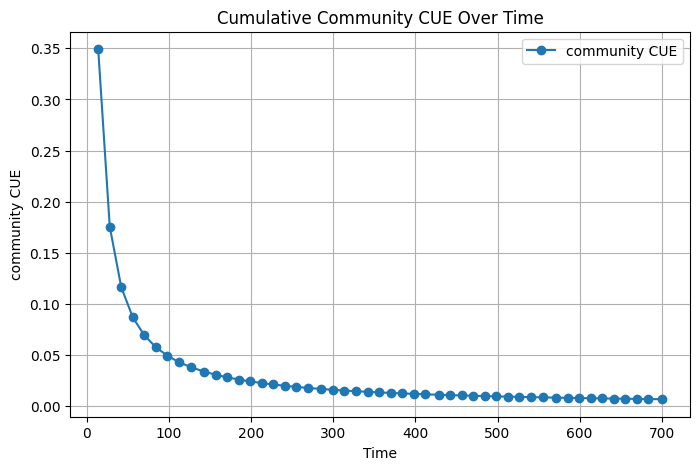

In [14]:
# visualization
plt.figure(figsize=(8, 5))
plt.plot(sol.t[time_indices[1:]], community_cue, marker='o', linestyle='-', label='community CUE')
plt.xlabel('Time')
plt.ylabel('community CUE')
plt.title('Cumulative Community CUE Over Time')
plt.legend()
plt.grid()
plt.show()

We are also able to calculate th instataneous CUE according to the change of resource and biomass between adjacent time points:
$$
CUE = \frac{C_t - C_(t-1)}{R_(t-1) - R_t + \text{inflow} \times \Delta t}
$$

Time: 14.05, community CUE: 0.0090
Time: 28.09, community CUE: 0.0067
Time: 42.14, community CUE: 0.0048
Time: 56.19, community CUE: 0.0033
Time: 70.23, community CUE: 0.0023
Time: 84.28, community CUE: 0.0015
Time: 98.33, community CUE: 0.0010
Time: 112.37, community CUE: 0.0007
Time: 126.42, community CUE: 0.0004
Time: 142.81, community CUE: 0.0002
Time: 156.86, community CUE: 0.0002
Time: 170.90, community CUE: 0.0001
Time: 184.95, community CUE: 0.0001
Time: 199.00, community CUE: 0.0000
Time: 213.04, community CUE: 0.0000
Time: 227.09, community CUE: 0.0000
Time: 241.14, community CUE: 0.0000
Time: 255.18, community CUE: 0.0000
Time: 269.23, community CUE: 0.0000
Time: 285.62, community CUE: 0.0000
Time: 299.67, community CUE: 0.0000
Time: 313.71, community CUE: 0.0000
Time: 327.76, community CUE: 0.0000
Time: 341.81, community CUE: 0.0000
Time: 355.85, community CUE: 0.0000
Time: 369.90, community CUE: 0.0000
Time: 383.95, community CUE: 0.0000
Time: 397.99, community CUE: 0.0000

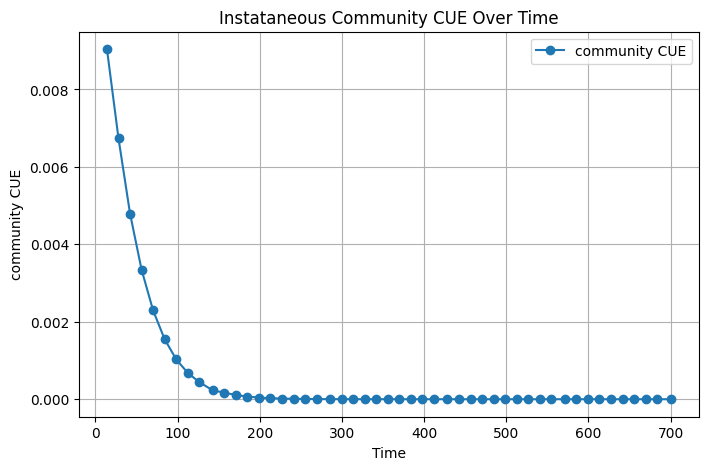

In [15]:
# calculate the instataneous community CUE between adjacent time points
dR2 = (R_selected[:-1].sum(axis=0) - R_selected[0:].sum(axis=0)) 
dR2 = dR2[1:] + 12 * (sol.t[time_indices[1:]] - sol.t[time_indices[:-1]])
dC2 = C_selected[0:].sum(axis=0) - C_selected[:-1].sum(axis=0)
dC2 = dC2 [1:] 
community_cue2 = dC2 / dR2
# print output
for i, t_idx in enumerate(time_indices[1:]):
    print(f"Time: {sol.t[t_idx]:.2f}, community CUE: {community_cue2[i]:.4f}")

# visualization
plt.figure(figsize=(8, 5))
plt.plot(sol.t[time_indices[1:]], community_cue2, marker='o', linestyle='-', label='community CUE')
plt.xlabel('Time')
plt.ylabel('community CUE')
plt.title('Instataneous Community CUE Over Time')
plt.legend()
plt.grid()
plt.show()

As the system approaches equilibrium, the community CUE also converges toward zero.

Current problem is how to define the equilibrium state. We could define it by the first time point when dC/dt first approach 0.

System reached steady state at t = 344.15
Steady-state Biomass (C): [5.62921212e-05 9.35249050e-02 1.48270568e-03 5.07881326e+00
 1.84675116e-03 1.07011908e-01 5.64458121e-01 9.23456213e+00
 3.59946303e+00 1.27428893e+01 1.37896159e+00 6.82954186e-05
 9.53340506e-01 4.76333521e-02 3.77924104e+00 3.78288585e-04
 5.82480482e-04 2.20471765e+01 1.92956607e-01 5.07313237e-05]
Steady-state Resources (R): [0.31146635 0.30590731 0.29000272 0.27189924 0.2580423  0.39349026
 0.29483328 0.29745045 0.29039679 0.27515683 0.26441574 0.26094984]


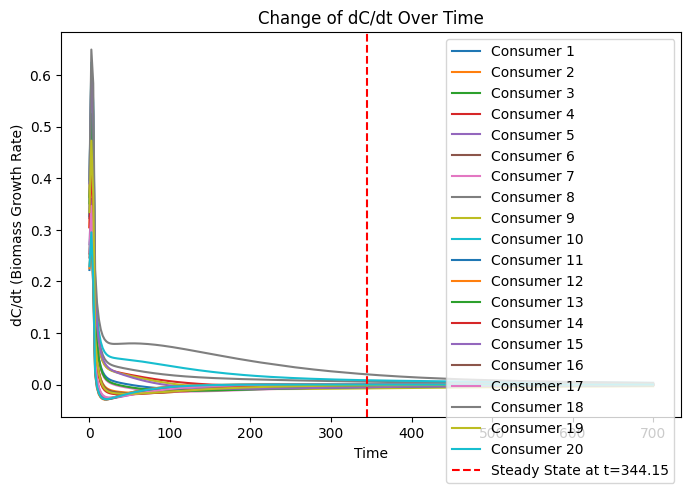

In [ ]:
# Set the equilibrium threshold
tolerance = 0.02

# Compute the numerical derivative of dC/dt
dC_dt_numeric = np.gradient(sol.y[:N, :], sol.t, axis=1)  # (N, T)

# Step-by-step check to find the equilibrium state of dC/dt
t_steady = None
for idx in range(len(sol.t)):
    if np.all(np.abs(dC_dt_numeric[:, idx]) < tolerance):  # Check if all dC/dt values are below the threshold
        t_steady = sol.t[idx]  # Record the equilibrium time
        C_steady = sol.y[:N, idx]  # Record the steady-state biomass (C)
        R_steady = sol.y[N:, idx]  # Record the steady-state resource abundance (R)
        break  # Stop searching once equilibrium is found

# Print the results
if t_steady is not None:
    print(f"System reached steady state at t = {t_steady:.2f}")
    print(f"Steady-state Biomass (C): {C_steady}")
    print(f"Steady-state Resources (R): {R_steady}")
else:
    print("System did not reach steady state within the simulation time.")

# Plot the change of dC/dt over time
plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(sol.t, dC_dt_numeric[i], label=f'Consumer {i+1}')
if t_steady is not None:
    plt.axvline(x=t_steady, color='r', linestyle='--', label=f'Steady State at t={t_steady:.2f}')
plt.xlabel("Time")
plt.ylabel("dC/dt (Biomass Growth Rate)")
plt.title("Change of dC/dt Over Time")
plt.legend()
plt.show()

In [17]:
# community CUE
# Compute total resource consumed by consumers
total_resource_consumed = np.sum(rho) *t_steady  - np.sum(R_steady)
# Compute biomass growth
biomass_growth = np.sum(C_steady) - np.sum(C0)
CUE_community = biomass_growth/total_resource_consumed
print(f"Community-level Carbon Use Efficiency (CUE): {CUE_community:.4f}")

Community-level Carbon Use Efficiency (CUE): 0.0140


##### **Method 2 Distribution of species CUE**

The distribution of CUE value of each species can also more or less represent the community level carbon usage efficiency.

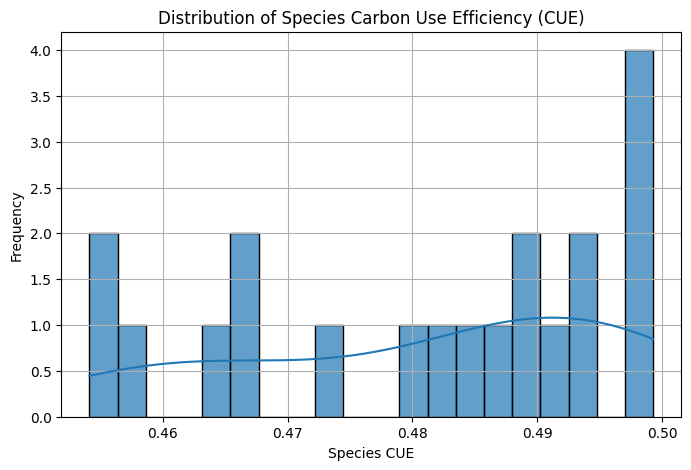

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(CUE, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel("Species CUE")
plt.ylabel("Frequency")
plt.title("Distribution of Species Carbon Use Efficiency (CUE)")
plt.grid(True)
plt.show()

However, in most cases, **different species contribute unequally to the community** because of variation in species abundance and uneven distribution of functional traits.

Community CUE is mostly influenced by dominant or high abundance species. For example, if a species has a low CUE and is rare, its effect on community CUE is much smaller than that of a high-CUE, high-abundance species.

## **Community-level characterization**

We aim to identify traits that may influence coalescence outcomes, as our focus is coalescence of different functional groups rather than different strains. Therefore, it is crucial to find some traits influencing community structure or function.

### **CUE**

Carbon usage efficiency reflects the ability to deplete resources and has been shown to be strongly correlated with species survival and extinction during community assembly. We look forward to similar pattern during coalescence.

There is also a connection between species richness and variance of species level CUE. Lower variance allows the space for more species to coexist, leading to high richness.

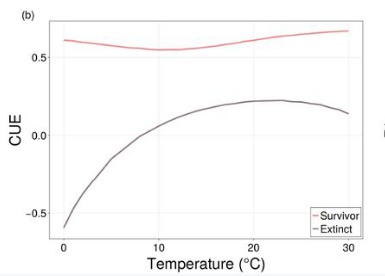
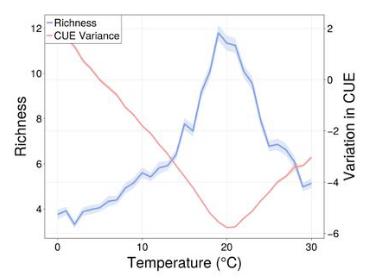

https://doi.org/10.32388/M1XFXL

### **Niche overlap**

According to competitive exclusion principle, species competing for identical resources connot stably coexist. Niche partition, which means species utilizing different resources, leading to coexistence. In our model, the niche partition could be controled by the function 
>u = param_3D.modular_uptake(N, M, N_modules, s_ratio, λ_u, σ)  


Divide the resources into different groups `N_modules` and assign different consumers to specialize in specific resource groups, while also controlling the degree of specialization `s_ratio`.
We can get the resource uptake distribution for each species and assess their similarity.

### **Interaction coefficient**

The effective interaction coefficients of the ELV system is 
$$
\alpha_{ij} = \sum_{a} u_{ia} (1 - l_{a}^{i}) \frac{\partial \hat{R}_a}{\partial C_j}
$$

In our system we will get a matrix and it illustrates the pairwise interaction between different species. If it's positive, it means the relationship among these two species is cooperative and negative indicating competitive. 
The abundance change of species j will affect species i indirectly through resource

### **Abundance**

Native species abundance regulates resistance to non-native invasions. Resident species with higher abundance are more resistant to invasion because they leave little niche space for an invader to occupy.
https://doi.org/10.1093/forsci/fxy059

The initial abundance of an invading microbe (propagule pressure) is a critical determinant of invasion success. Generally, the more invader cells or propagules introduced, the higher the chance that some will survive competition and establish a population. 

Is there chances for rare species? (Think about niche space or enemy release hypothesis)?

Some researchers tried to combine three-pronged framework of traits of invador, environmental context, and propagule pressure together to make some prediction about invasive event.
https://doi.org/10.1038/s44185-023-00019-1

### **Network structure**

The interaction coefficient aij can actually form a matrix $C =[\alpha_{ij}]$. Based on the elements in $C$, we can construct a complex network, and the value of the element represents the connection coefficient between nodes (species). Obviously, only when the element in the matrix is ​​0 does it mean ``unconnected'', so the complex network is likely to have a large number of edges (connections). To simplify this problem, we can assume a threshold $r_c$ to filter weak connections and retain strong connections. Therefore, we can get the simplified adjacency matrix $A = [a_{ij}]$:

$$a_{ij}=\left\{\begin{array}{l}1,|C_{ij}|\geq r_c,\\0,|C_{ij}|<r_c,\end{array}\right.$$

#### Structural measure

Complex networks enabled mapping characteristics of system into topological structures. An undirected and unweighted complex network was described as a graph $G = (V,E)$, where $V$ represents the set of nodes (specises), and  $E$ represents the set of edges connecting these nodes.  In the symmetric adjacency matrix $A$, which is a binary matrix, $a_{ij} = 1$ denotes the existence of an edge between nodes $i$ and $j$, while $a_{ij} = 0$ indicates the absence of such a connection.

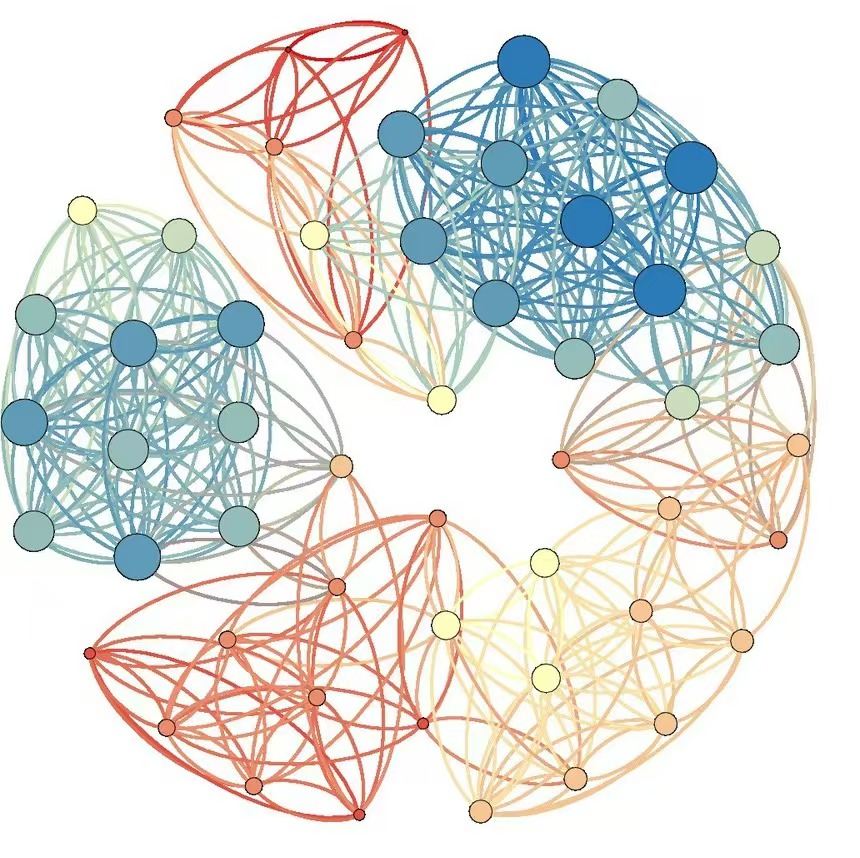

Node degree ($k_i$) signifies the number of connections a node possesses. The degree of node $i$ is specified as follows:
$$
{{k}_{i}}=\sum\limits_{j}{{{a}_{ij}}}=\sum\limits_{i=1}{{{a}_{ij}}}.
$$


The average degree is the  mean of $k_i$ for all nodes in the network and is computed as follows:
$$
\left\langle k \right\rangle =\frac{1}{N}\sum\limits_{i}{{{k}_{i}}}=\frac{1}{N}\sum\limits_{i}{\sum\limits_{j}{{{a}_{ij}}}}.
$$


The clustering coefficient ($c_i$) measures the density of connections among the neighbors of a specific node $i$. It is calculated as the ratio of the number of connections among the neighbors to the maximum potential connections among them. The algorithm for calculating $c_i$ is as follows:
$$
{{c}_{i}}=\frac{2{{e}_{i}}}{{{k}_{i}}\left( {{k}_{i}}-1 \right)}=\frac{2}{{{k}_{i}}\left( {{k}_{i}}-1 \right)}\sum\limits_{j,h}{{{a}_{ij}}{{a}_{ih}}{{a}_{jh}}},
$$
where $e_i$ represents the number of linked pairs among node $i$'s neighbors, and $c_i$ is restricted to the range $[0, 1]$.


The average clustering coefficient for all nodes is defined as below:
$$
\left\langle {{c}_{i}} \right\rangle =\frac{1}{N}\sum\limits_{i=1}{{{c}_{i}}}.
$$
A high average clustering coefficient suggests that nodes tend to create tightly connected communities, which is indicative of a network with a significant degree of local redundancy and robustness to certain types of failures or attacks.




The number of edges that connect nodes $i$ and $j$ is known as the path length, and the distance $d_{ij}$ is the shortest between them. The maximum value of the shortest path lengths $d_{ij}$ is the diameter $D$.
$$
D=\underset{ij}{\mathop{\max }}\,{{d}_{ij}}.
$$


The average path length $\left\langle {{d}_{ij}} \right\rangle$ quantifies the mean distance between random pairs of nodes $i$ and $j$:
$$
\left\langle {{d}_{ij}} \right\rangle =\frac{1}{N(N-1)}\sum\limits_{i,j}{{{d}_{ij}}}.
$$

Betweenness is a measure of the significance of individual nodes, indicating a node's ability to regulate information flow within the network. As a node's betweenness increases, there is a higher probability of information congestion in the network. The calculation of betweenness is as follows:
$$
{{B}_{i}}=\sum\limits_{j\ne l\ne i}{\frac{{{N}_{jl}}\left( i \right)}{{{N}_{jl}}}},
$$
where $N_{jl}$ represents the total count of shortest paths from node $j$ to $l$, and $N_{jl}(i)$ signifies the number of these paths that pass through node $i$.


Modularity ($Q$) is a metric for evaluating the strength of the separation of a network into clusters. A high $Q$ value indicates that nodes within the same community tend to share common characteristics. It is defined as follows:
$$
Q=\frac{1}{2m}\sum\limits_{i}{\sum\limits_{j}{\left[ \left( {{a}_{ij}}-\frac{{{k}_{i}}{{k}_{j}}}{2m} \right)\cdot \delta \left( {{u}_{i}},{{u}_{j}} \right) \right]}},
$$
where $m=\frac{1}{2}\sum\limits_{i}{\sum\limits_{j}{{{a}_{ij}}}}$, $u_i$ refers to the community assignment of node $i$. In the case of $u = v$, the function  $\delta (u, v)$  equals 1 and 0 otherwise.



## **Coalescence**

We combined two community together by giving them different indices.

### **Method**

We created a resource pool as well as a species pool for all species. For example, Community 1 used 3 resources during evolution, and Community 2 used 2 resources, and the merged community has 5 resources. In this assumption, when the community evolves independently, it only converts resources into resources that exist in the community. For example, the species in Community 1 will convert its 3 resources into 2 resources in Community 2 only during coalescence.

We assume that there is a species pool containing $N_{pool}$ species. And assume a resource pool containing $M_{pool}$ resources. Ideally, they can form a large community, but this is not our purpose. We first assume that they can form a large uptake matrix $u$ and leakage tensor $l$. $u$ and $l$ contain "the uptake rate for all resources" and "the ability to convert any resource" of all species.

Randomly select $N_1$ species from the rows of $u$ and $M_1$ resources from the columns of $u$ to form the uptake matrix $u_1$ of Community 1. Randomly select $N_2$ species from the remaining rows of $u$ and $M_2$ resources from the remaining columns of $u$ to form the uptake matrix $u_2$ of Community 2. Record the indexes of these species and resources, and get the leakage tensors $l_1$ and $l_2$ corresponding to the two communities in $l$.

After setting other parameters, simulate Communities 1 and 2, record the equilibrium state of resources as $R_{e1}$ and $R_{e2}$, and the equilibrium state of species as $C_{e1}$ and $C_{e2}$.

For the aggregation process, we cannot directly merge $u_1$ and $u_2$ into $u_3$ as in method 1, because they have different sizes. Therefore, we concatenate the indexes of species in Community 1 and 2, and the indexes of resources in Community 1 and 2, and use these indexes to construct $u_3$. Similarly, we construct $l_3$ based on these indexes. Merge $C_{e1}$ and $C_{e2}$ into the initial state $C_{03}$ of species in $u_3$. Merge $R_{e1}$ and $R_{e2}$ into the initial state $R_{03}$ of species in $u_3$. We assume that resources are replenished and decayed at the previous rate, and the fusion process will not affect the maintenance cost of all species. After setting these, simulate the new community.

In [12]:
import numpy as np
import os
import sys
sys.path.append(os.path.expanduser("~/Documents/MiCRM/code"))
import param
import CUE
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [13]:
N_pool = 1000  # Species pool size
M_pool = 20     # Resource pool size

Then, we created uptake and leakage matrix for all these species and resources

In [14]:
λ = 0.2        # Total leakage rate
N_modules = 5  # Number of modules
s_ratio = 10.0 # Modularity ratio
N1 = 10
M1 = 5
m1 = np.full(N1, 0.2)  # maintaining cost rate
N2 = 10
M2 = 5
m2 = np.full(N2, 0.2)
# Generate uptake matrix and leakage tensor for the species pool
u_pool = param.modular_uptake(N_pool, M_pool, N_modules, s_ratio)
l_pool = param.generate_l_tensor(N_pool, M_pool, N_modules, s_ratio, λ)
# Set rho and omega for the resource pool
rho_pool = np.full(M_pool, 0.6)
omega_pool = np.full(M_pool, 0.1)

For community 1, we randomly selected some indices.

In [15]:
# Community 1
species_indices1 = np.random.choice(N_pool, N1, replace=False)
resource_indices1 = np.random.choice(M_pool, M1, replace=False)

Then select rows in the uptake matrix and submatrix of leakage.

In [16]:
u1 = u_pool[np.ix_(species_indices1, resource_indices1)]
l1 = l_pool[np.ix_(species_indices1, resource_indices1, resource_indices1)]

As well as defining other parameters

In [17]:
lambda_alpha1 = np.full(M1, λ)
rho1 = rho_pool[resource_indices1]
omega1 = omega_pool[resource_indices1]

For community 2, we select species from the rest part of the species pool

In [18]:
remaining_species = np.setdiff1d(np.arange(N_pool), species_indices1)
species_indices2 = np.random.choice(remaining_species, N2, replace=False)

Construct the resource subset for the second community based on the difference in required resource numbers:

If M1 > M2, randomly select M2 resources from the first community’s resource set.
If M1 < M2, randomly add (M2 - M1) resources from the unused resource pool.
If M1 = M2, directly copy the first community’s resource set.

In [19]:
if M1 > M2:
    resource_indices2 = np.random.choice(resource_indices1, M2, replace=False)
elif M1 < M2:
    remaining_resources = np.setdiff1d(np.arange(M_pool), resource_indices1)
    additional_resources = np.random.choice(remaining_resources, M2 - M1, replace=False)
    resource_indices2 = np.concatenate([resource_indices1, additional_resources])
else:
    resource_indices2 = resource_indices1.copy()

Set up the parameters for community 2

In [20]:
u2 = u_pool[np.ix_(species_indices2, resource_indices2)]
l2 = l_pool[np.ix_(species_indices2, resource_indices2, resource_indices2)]
lambda_alpha2 = np.full(M2, λ)
rho2 = rho_pool[resource_indices2]
omega2 = omega_pool[resource_indices2]

Define ODE problem

In [21]:
def dCdt_Rdt(t, y, u, l, N, M, m, rho, omega):
    C = y[:N]
    R = y[N:]
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    for i in range(N):
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - λ) for alpha in range(M)) - C[i] * m[i]
    
    for alpha in range(M):
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))
    
    return np.concatenate([dCdt, dRdt])

# Time span for simulation
t_span = (0, 500)
t_eval = np.linspace(*t_span, 300)

Solve it for each parental community

In [22]:
# Simulate Community 1
C0_1 = np.full(N1, 0.01)  # Initial consumer abundance
R0 = np.full(M1, 1)        # Initial resource abundance
Y0_1 = np.concatenate([C0_1, R0])
sol1 = solve_ivp(dCdt_Rdt, t_span, Y0_1, t_eval=t_eval, args=(u1, l1, N1, M1, m1, rho1, omega1))
ce1 = sol1.y[:N1, -1]  # Consumer abundance at equilibrium
re1 = sol1.y[N1:, -1]  # Resource abundance at equilibrium

# Simulate Community 2
C0_2 = np.full(N2, 0.01)
Y0_2 = np.concatenate([C0_2, R0])
sol2 = solve_ivp(dCdt_Rdt, t_span, Y0_2, t_eval=t_eval, args=(u2, l2, N2, M2, m2, rho2, omega2))
ce2 = sol2.y[:N2, -1]
re2 = sol2.y[N2:, -1]

Merge these two community into community 3 according to indices

In [23]:
species_indices3 = np.concatenate([species_indices1, species_indices2])
resource_indices3 = resource_indices1 if M1 >= M2 else resource_indices2
uu = u_pool[np.ix_(species_indices3, resource_indices3)]
ll = l_pool[np.ix_(species_indices3, resource_indices3, resource_indices3)]
m3 = np.concatenate([m1, m2])
lambda_alpha3 = np.full(len(resource_indices3), λ)
rho3 = rho_pool[resource_indices3]
omega3 = omega_pool[resource_indices3]
N3 = N1 + N2
M3 = len(resource_indices3)

Simulate the dynamics of community 3

In [24]:
C0_3 = np.concatenate([ce1, ce2])
R0_3 = re1 + re2
Y0_3 = np.concatenate([C0_3, R0_3])
sol3 = solve_ivp(dCdt_Rdt, t_span, Y0_3, t_eval=t_eval, args=(uu, ll, N3, M3, m3, rho3, omega3))

plot community dynamics for all three communities in the same level

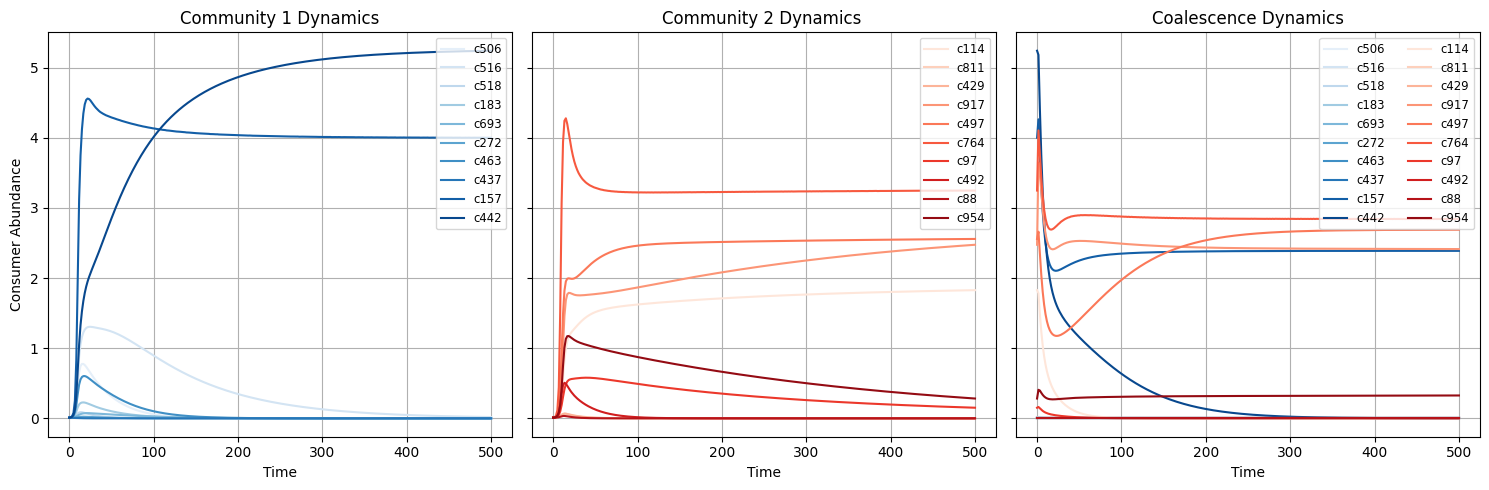

In [25]:
# Plot biomass change over time
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# Plot for Community 1
cmap1 = plt.get_cmap("Blues")
for i, idx in enumerate(species_indices1):
    axes[0].plot(sol1.t, sol1.y[i], color=cmap1((i + 1) / (N1 + 1)), label=f"c{idx}")
axes[0].set_title('Community 1 Dynamics')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Consumer Abundance')
axes[0].grid(True)
axes[0].legend(loc='upper right', fontsize='small')
# Plot for Community 2
cmap2 = plt.get_cmap("Reds")
for i, idx in enumerate(species_indices2):
    axes[1].plot(sol2.t, sol2.y[i], color=cmap2((i + 1) / (N2 + 1)), label=f"c{idx}")
axes[1].set_title('Community 2 Dynamics ')
axes[1].set_xlabel('Time')
axes[1].grid(True)
axes[1].legend(loc='upper right', fontsize='small')
# Plot for Community 3 (merged)
for i, idx in enumerate(species_indices1):
    axes[2].plot(sol3.t, sol3.y[i], color=cmap1((i + 1) / (N1 + 1)), label=f"c{idx}")
for i, idx in enumerate(species_indices2):
    axes[2].plot(sol3.t, sol3.y[N1 + i], color=cmap2((i + 1) / (N2 + 1)), label=f"c{idx}")
axes[2].set_title('Coalescence Dynamics')
axes[2].set_xlabel('Time')
axes[2].grid(True)
axes[2].legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

Then, we compare the separation of species CUE between survival species and extinct species

In [26]:
sol_list = [sol1, sol2, sol3]  # List of community solutions
N_list = [N1, N2, N3]  # Number of consumers for each community
u_list = [u1, u2, uu]
R0_list = [R0, R0, R0_3]
l_list = [l1, l2, ll]
m_list = [m1, m2, m3]
M_list = [M1, M2, M3]
num_communities = len(sol_list)  # Number of communities
data_to_save = [] 
for i in range(num_communities):
    C_final = np.array(sol_list[i].y[:, -1])  # shape: (num_species,)
    
    community_CUE, species_CUE = CUE.compute_community_CUE2(
        sol_list[i], N_list[i], u_list[i], R0_list[i], l_list[i], m_list[i]
    )
    species_CUE = np.array(species_CUE, dtype=float)  # shape: (num_species_filtered,)

    surviving_CUE = []
    extinct_CUE = []
    # Separate surviving and extinct species based on CUE threshold
    surviving_CUE = [species_CUE[j] for j in range(len(species_CUE)) if C_final[j] >= 0.1]
    extinct_CUE = [species_CUE[j] for j in range(len(species_CUE)) if C_final[j] < 0.1]
    surviving_species_count = len(surviving_CUE)


    mean_surviving_CUE = np.mean(surviving_CUE) if surviving_CUE else np.nan
    mean_extinct_CUE = np.mean(extinct_CUE) if extinct_CUE else np.nan

    print(f"Community {i+1}:")
    print(f"  Surviving species count: {surviving_species_count}")
    print(f"  Mean CUE (Surviving): {mean_surviving_CUE:.4f}")
    print(f"  Mean CUE (Extinct):   {mean_extinct_CUE:.4f}")
    print("-" * 50)


    for val in surviving_CUE:
        data_to_save.append({
            "Community": i + 1,
            "Status": "Survival",
            "CUE": val
        })
    for val in extinct_CUE:
        data_to_save.append({
            "Community": i + 1,
            "Status": "Extinction",
            "CUE": val
        })

Community 1:
  Surviving species count: 2
  Mean CUE (Surviving): 0.3945
  Mean CUE (Extinct):   -0.2976
--------------------------------------------------
Community 2:
  Surviving species count: 6
  Mean CUE (Surviving): 0.2801
  Mean CUE (Extinct):   -0.1319
--------------------------------------------------
Community 3:
  Surviving species count: 5
  Mean CUE (Surviving): 0.6909
  Mean CUE (Extinct):   0.3829
--------------------------------------------------


Visualization in R

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


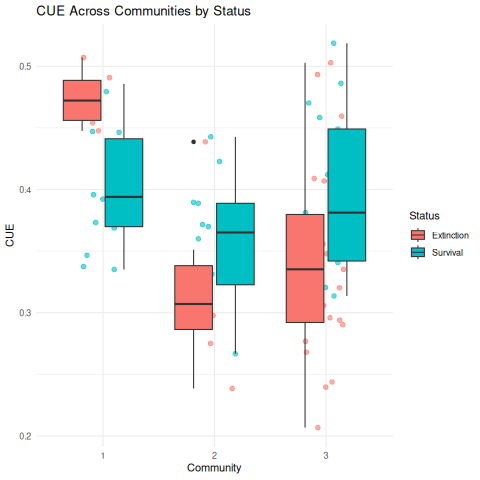

In [28]:
%%R
setwd("/home/jiayi-chen/Documents/MiCRM/code")
library(ggplot2)
# Read the CSV file into R
df_combined <- read.csv("../data/CUE_distribution.csv")
# Create a boxplot of CUE by Status
boxplot(CUE ~ Status, 
        data = df_combined , 
        main = "Boxplot of CUE by Status",
        xlab = "Status (Survival vs. Extinction)",
        ylab = "CUE",
        col = c("gray", "green"))
# Create a boxplot of CUE by Community and Status using ggplot2
ggplot(df_combined, aes(x = factor(Community), y = CUE, fill = Status)) +
  geom_jitter(aes(color = Status), width = 0.2, alpha = 0.6, size = 2) + 
  geom_boxplot() +
  labs(title = "CUE Across Communities by Status",
       x = "Community",
       y = "CUE") +
  theme_minimal()
